© 2018 Suzy Beeler and Vahe Galstyan. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT) 

This exercise was generated from a Jupyter notebook. You can download the notebook [here](bacterial_growth.ipynb).
___

# Objective 

In this tutorial, we will discuss how we can describe bacterial growth (i.e. exponential growth) mathematically. Given this mathematical model of how bacteria grow, we will then analyze images to determine the growth rate of a bacterial colony. For now, we will determine the growth rate value that best describes our data by fitting "by eye." Later in the bootcamp, we will learn more rigorous ways to determine which parameter value(s) best describe our data.

# Mathematically describing bacterial growth

Provided a nutrient-rich environment, bacteria will continually multiply, resulting in exponential growth which we can describe mathematically. Let's assume that the growth rate of bacteria is $k$. If $N(t)$ is the number of bacteria at time $t$, after a time increment $\Delta t$, the number of bacteria will be

\begin{align}
N(t+\Delta t) = N(t) + k \, N(t) \Delta t.
\end{align}

Taking the $\Delta t \rightarrow 0$ limit, we obtain the time evolution equation for N(t)

\begin{align}
\frac{N(t+\Delta t) - N(t)}{\Delta t} \approx \frac{\mathrm{d} N(t)}{\mathrm{d} t} = k N(t).
\end{align}

Knowing the initial number of bacteria, $N_0$, the solution to the above ordinary differential equation will be

\begin{align}
N(t) = N_0 e^{k t}.
\end{align}

The doubling time of bacteria, $\tau$, is also of interest. It's defined as the time it takes for a bacterium to multiply, i.e.

\begin{align}
N(t+\tau) = 2 N(t).
\end{align}

Substituting the solution for $N(t)$, we find

\begin{align}
N_0 e^{k(t+\tau)} &= 2N_0 e^{k t} \\
e^{k \tau} &= 2 \\
\tau &= \frac{\ln(2)}{k}.
\end{align}

Now that we have a mathematical description for how bacteria grow, we can analyze microscopy images of a bacterial colony over time to estimate the growth rate $k$ and the doubling time $\tau$.

# Analysis of bacterial colony images

Whenever we write code, we first need to import all the relevant packages that we will be using, as done below.

In [1]:
# import the necessary modules
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# for pretty plots
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14, \
    'xtick.labelsize' : 14, 'ytick.labelsize' : 14}
sns.set(rc=rc)

# for bulk acquisition of filenames
import glob

# for importing bacterial images
import skimage.io

Now, let's use the microscopy images of a growing bacterial colony to estimate the rate of bacterial growth. In the `data/` folder you can see microscopy images taken in *phase contrast* and *fluorescence* methods in 5 minute intervals. The phase images are named `ecoli_phase_xx.tif`, and the fluorescence ones are named `ecoli_TRITC_xx.tif`. Let's begin by taking a look at one of the fluorescence images. 

In [2]:
# read an example phase image
im = skimage.io.imread('./data/ecoli_growth/ecoli_TRITC_05.tif')

# take a look at its contents
im

array([[205, 205, 205, ..., 205, 205, 206],
       [204, 204, 205, ..., 204, 205, 205],
       [204, 204, 205, ..., 204, 203, 203],
       ...,
       [205, 204, 204, ..., 203, 203, 203],
       [205, 204, 204, ..., 205, 205, 205],
       [205, 204, 204, ..., 205, 205, 205]], dtype=uint16)

Here we see that the image is just an array of integers. You might not be used to thinking of pictures in this way, but microscopy images in fact give us *quantitative* information, with each pixel in a 2D array being assigned a numerical value to describe the intensity, with larger numbers corresponding to brighter pixels. If we want to actually see the image (and not just the numerical values), we can call `plt.imshow()` on our image.

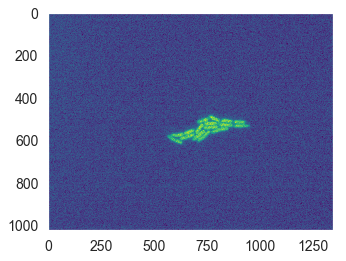

In [3]:
# show the image, with a nice color map
plt.imshow(im, cmap = plt.cm.viridis)

# Remove the grid that is shown by default
plt.grid(False)

Let's hover over the pixels and get a sense of what values the background and bacterial pixels have.

<IPython.core.display.Javascript object>


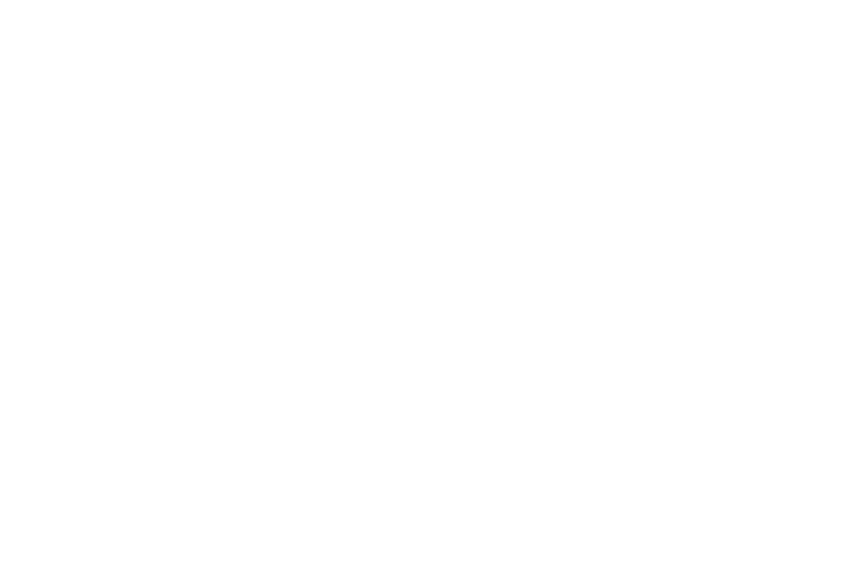

<IPython.core.display.Javascript object>


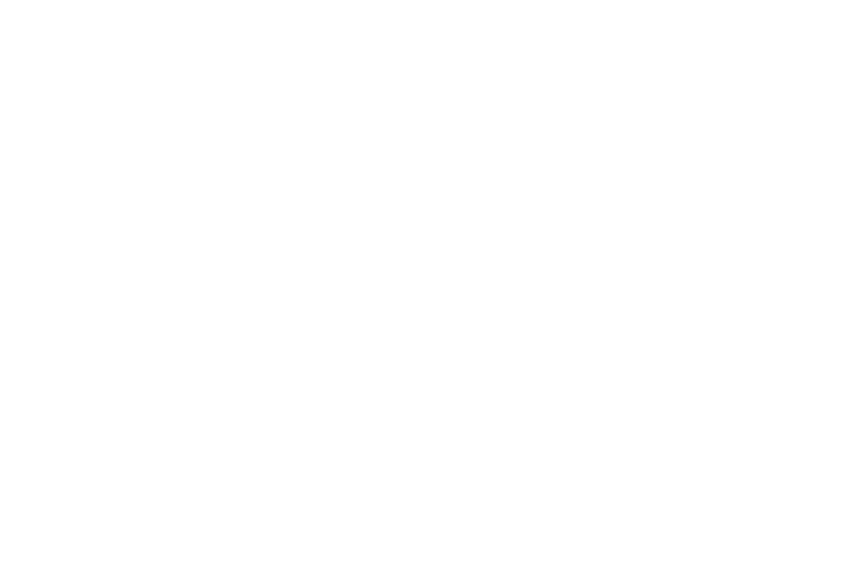

In [4]:
# allows us to interact with the image once it's displayed
%matplotlib notebook

plt.imshow(im, cmap=plt.cm.viridis)
plt.grid(False)

It seems like the background pixels have values around `205`, while the bacterial pixels have higher values of `210-220`. To see this more concretely, let's remember that this image contains *quantitative* data that we can plot. Below, let's plot a histogram of the pixel intensities. 

Text(0,0.5,'number of observations')

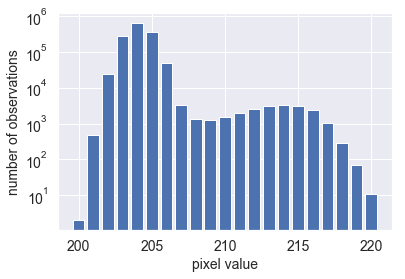

In [5]:
%matplotlib inline

# generate the image histogram
counts, bins = skimage.exposure.histogram(im)

# plot it as a bar plot
plt.bar(bins, counts)
plt.yscale('log')

# add appropriate labels.
plt.xlabel('pixel value')
plt.ylabel('number of observations')

We can more clearly see the two population of pixel values -- those that are dim, corresponding to the background and those that are bright, corresponding to bacteria. If we want the computer to be able to distinguish between bacteria and background (a process known as **segmenting** the image), we can use a **thresholding** approach, where we assign pixels above a certain value to `1` (indicating the pixel corresponds to bacteria) and pixels below a certain value to `0` (indicating the pixel corresponds to background). From the histogram above, a pixel intensity of `208` seems like a good threshold for distinguishing between these two populations of pixels. 

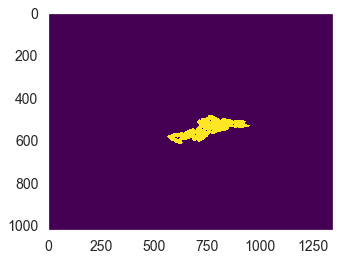

In [6]:
# Threshold value
threshold = 208

# Apply the threshold and show the segmented image
plt.imshow(im > threshold, cmap = plt.cm.viridis)
plt.grid(False)

Looks like thresholding did a decent job in isolating the bacterial cells! Let's follow the same procedure for an image at a later frame to make sure our threshold value work well for multiple images.

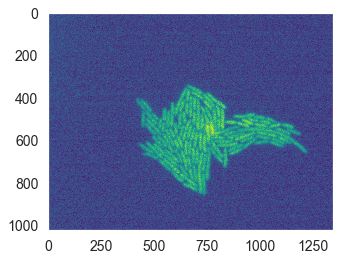

In [7]:
# Load the image
im = skimage.io.imread('./data/ecoli_growth/ecoli_TRITC_18.tif')

# Show the image
plt.imshow(im, cmap = plt.cm.viridis)
plt.grid(False)

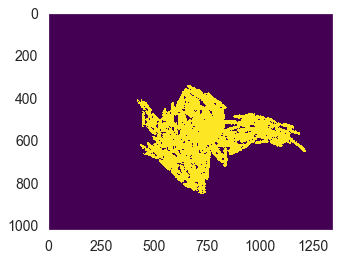

In [8]:
# Apply the threshold and show the segmented image
plt.imshow(im > threshold, cmap = plt.cm.viridis)
plt.grid(False)

This looks pretty good. Now that we've shown that our selected threshold works well for both early and late images in the sequence, we can now apply this thresholding approach to all of the images. To do this, we will be using the `glob.glob()` function, which will grab all the images with a given name (like `ecoli_TRITC_xx.tif`).

In [9]:
# Extract the names of all phase images
im_names = np.sort(glob.glob('./data/ecoli_growth/ecoli_TRITC_*.tif'))

# Take a look at some
im_names[0:5]

array(['./data/ecoli_growth/ecoli_TRITC_00.tif',
       './data/ecoli_growth/ecoli_TRITC_01.tif',
       './data/ecoli_growth/ecoli_TRITC_02.tif',
       './data/ecoli_growth/ecoli_TRITC_03.tif',
       './data/ecoli_growth/ecoli_TRITC_04.tif'], dtype='<U38')

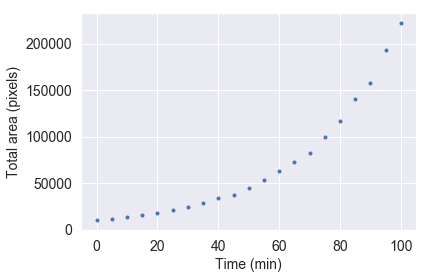

In [10]:
# number of frames
n_frames = len(im_names)

# an array to store the bacterial areas
area_tot = np.zeros(n_frames)

# extract the bacterial areas
for n in range(n_frames):
    
    # read the frame
    im = skimage.io.imread(im_names[n])

    # apply the threshold
    im_thresh = im > 208
    
    # save the area in our array
    area_tot[n] = np.sum(im_thresh)
    
# time resolution in minutes
dt = 5

# measurement times
times = dt * np.arange(n_frames)

# plot the time dependence of the bacterial area
plt.plot(times, area_tot, '.')
plt.xlabel('Time (min)')
plt.ylabel('Total area (pixels)')
plt.show()

This in fact looks like an exponential growth curve! Since we are interested in the growth rate $\lambda$, let's rescale the areas so that in the first frame the area is normalized to `1`.

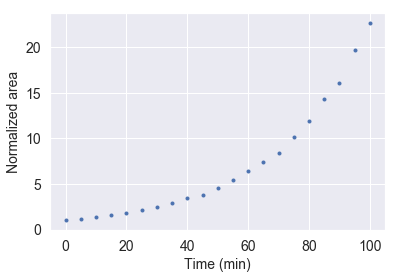

In [11]:
# area normalization
area_tot_norm = area_tot / area_tot[0]

# plot the normalized area
plt.plot(times, area_tot_norm, '.')
plt.xlabel('Time (min)')
plt.ylabel('Normalized area')
plt.show()

We need to find the value of the growth rate $\lambda$ which can best explain the curve above. To that end, let's introduce a fitting error function defined as

\begin{align}
\mathrm{Err}(\lambda) = \sum_{i=1}^{N} \left(f_i- \hat{f}_i(\lambda) \right)^2,
\end{align}

where the iteration takes place over each frame. Here $f_i$ represents the normalized area at the $i^{\text{th}}$ frame, and $\hat{f}_i(\lambda) = \exp(\lambda \, t_i)$ is the theoretical prediction of the fractional growth for a given value of the growth rate. Let's write a function that evaluates the error for a given choice of $\lambda$.

In [12]:
def err(norm_area, times, rate):
    """
    Returns the sum of the errors for the theory curve (given a the provided rate)
    versus the provided data (norm_area)
    """
    
    theory = np.exp(rate*times)
    
    return np.sum((theory - norm_area)**2)

To determine the growth rate of our bacterial colony, we should choose the value of $\lambda$ that minimizes the fitting error. Let's plot the error for different values of $\lambda$ and identify the optimal value. 

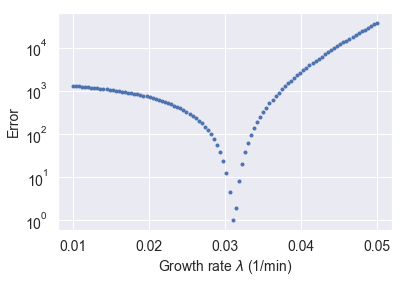

In [13]:
# number of points to plot
n_points = 100

# range of k's to test
ks = np.linspace(0.01, 0.05, n_points)

# initilize an array of error
errors = np.zeros(n_points)

# for each k, call our err funtion to determine the amount of error
for i in range(n_points):
    errors[i] = err(area_tot_norm, times, ks[i])
    
# plot the erros over the values of lambda    
plt.plot(ks, errors, '.')
plt.ylabel('Error')
plt.xlabel('Growth rate $\lambda$ (1/min)')
plt.yscale('log')
plt.show()

The minimum seems to be around $0.03$, but we can find the exact value as shown below.

In [14]:
# index of the optimal k
ind_optimal = np.where(errors == np.min(errors))

# optimal k
k_fit = ks[ind_optimal]

# show the optimal fit
print(k_fit)

[0.0310101]


The optimal fit is $k \approx 0.03$ min$^{-1}$. It corresponds to a doubling time of $\tau \approx 23$ minutes, which is consistent with what we see with *E. coli* grown in the lab. In the final step, let's add the best growth curve on top of the experimental one to visually see the goodness of fit.

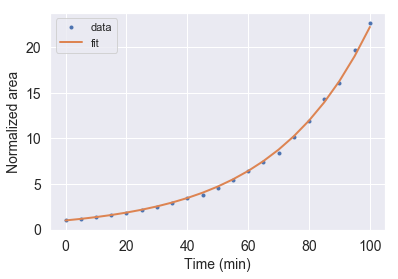

In [15]:
# plot the normalized area
plt.plot(times, area_tot_norm, '.')
plt.plot(times, np.exp(k_fit*times))
plt.xlabel('Time (min)')
plt.ylabel('Normalized area')
plt.legend(['data','fit'])
plt.show()